In [1]:
%matplotlib inline

# Demonstration of how to fit halo MAHs with the `diffmah` model

This notebook illustrates a worked example of how to fit an individual halo MAH with the diffmah model. For a parallelized script, see `history_fitting_script.py`.

## Load a block of target data

These data can be downloaded from the site hosting the project data. But in principle the fitting function should work main progenitors from any sim.

In [3]:
from diffmah.load_mah_data import load_tng_data, TASSO
_ret = load_tng_data(data_drn=TASSO)
halo_ids, log_mahs, t_tng, log_mah_fit_min = _ret

## Pick a particular example halo history to fit

In [6]:
from diffmah.fit_mah_helpers import get_loss_data
from diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.utils import jax_adam_wrapper

itest = 0
log_mah_sim = log_mahs[itest, :]

p_init, loss_data = get_loss_data(t_tng, log_mah_sim, log_mah_fit_min)

## Use Adam to fit the MAH with the smooth model

In [7]:
n_step = 200
_res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
p_best, loss, loss_arr, params_arr, fit_terminates = _res

## Inspect the loss curve to see if we're converged 

(or if fewer steps can be taken for faster fitting)

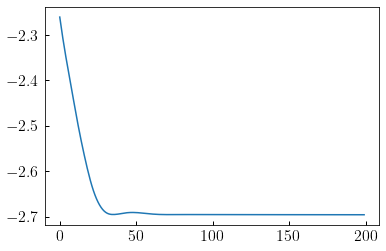

In [8]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_arr))

## Grab the unbounded values of the best-fit parameters

In [9]:
logtc, ue, ul = p_best
logt_target, log_mah_target, logtmp, k, logmp_fit = loss_data

## Transform the unbounded parameters to the actual `diffmah` parameters

In [10]:
from diffmah.individual_halo_assembly import _get_early_late
early, late = _get_early_late(ue, ul)

## Calculate the MAH using the best-fit model

In [11]:
from diffmah.individual_halo_assembly import _calc_halo_history

tarr = np.linspace(0.75, 13.8, 500)
lgtarr = np.log10(tarr)
dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late)

## Compare the model to the simulated MAH

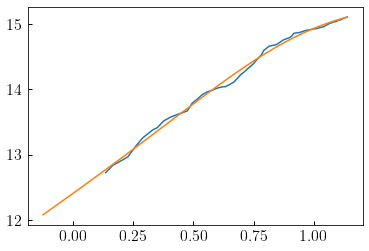

In [12]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logt_target, log_mah_target)
__=ax.plot(lgtarr, log_mah_fit)